In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image = cv2.cvtColor(cv2.imread('lena.png'), cv2.COLOR_BGR2RGB)

In [3]:
def apply_convolution(image, kernel):
    return apply_correlation(image, kernel[::-1, ::-1])

def apply_correlation(image, kernel):
    (h, w, c) = image.shape
    (kh, kw) = kernel.shape

    pad_h = kh // 2
    pad_w = kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=0)
    
    convolved_image = np.zeros_like(image)
    
    for channel in range(c):
        for i in range(h):
            for j in range(w):
                region = padded_image[i:i + kh, j:j + kw, channel]
                convolved_value = np.sum(region * kernel)
                convolved_image[i, j, channel] = convolved_value

    convolved_image = np.clip(convolved_image, 0, 255)
    
    return convolved_image

def apply_median(image, size):
    (h, w, c) = image.shape
    (kh, kw) = (size, size)

    pad_h = kh // 2
    pad_w = kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=-1)
    
    median_image = np.zeros_like(image)
    
    for channel in range(c):
        for i in range(h):
            for j in range(w):
                region = padded_image[i:i + kh, j:j + kw, channel]
                region_valid = np.sort(region[region != -1])
                median_image[i, j, channel] = region_valid[len(region_valid) // 2]

    median_image = np.clip(median_image, 0, 255)
    
    return median_image

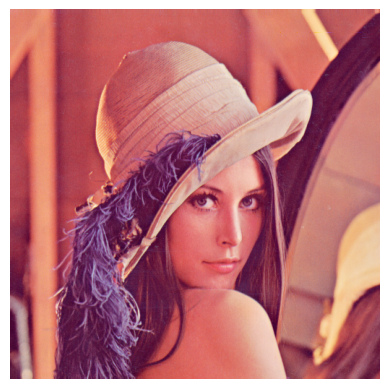

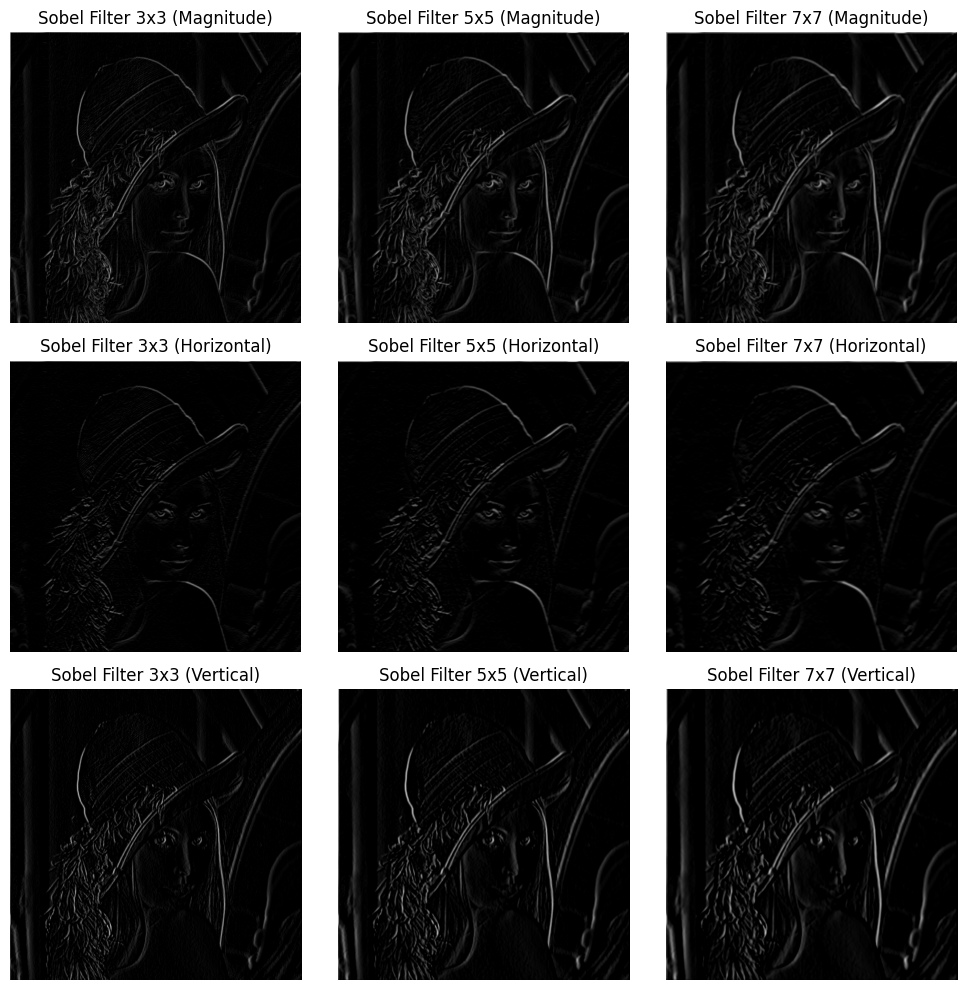

In [4]:
def generate_sobel_kernel(size):
    gx = np.zeros((size, size), dtype=np.float32)
    gy = np.zeros((size, size), dtype=np.float32)

    indices = np.indices((size, size), dtype=np.float32)
    cols = indices[0] - size // 2
    rows = indices[1] - size // 2
    squared = cols ** 2 + rows ** 2

    np.divide(cols, squared, out=gy, where=squared!=0)
    np.divide(rows, squared, out=gx, where=squared!=0)
    gy = -gy / np.sum(np.absolute(gy))
    gx = -gx / np.sum(np.absolute(gx))
    return gy, gx

cache = dict()

def apply_full_sobel(mat, n):
    sob_x, sob_y = generate_sobel_kernel(n)

    g_mat = np.expand_dims(np.dot(mat[..., :3], [0.2989, 0.5870, 0.1140]), axis=-1)  

    h = apply_convolution(g_mat, sob_x)[..., 0]
    v = apply_convolution(g_mat, sob_y)[..., 0]

    cache[f"sob_h_{n}"] = h
    cache[f"sob_v_{n}"] = v

    edges = np.sqrt(h ** 2 + v ** 2)
    edges = (edges / np.max(edges)) * 255
    
    return np.floor(edges).astype(int)

images = [apply_full_sobel(image, 3), apply_full_sobel(image, 5), apply_full_sobel(image, 7), 
          cache["sob_h_3"], cache["sob_h_5"], cache["sob_h_7"],
            cache["sob_v_3"], cache["sob_v_5"], cache["sob_v_7"]
          ]
titles = ["Sobel Filter 3x3 (Magnitude)", "Sobel Filter 5x5 (Magnitude)", "Sobel Filter 7x7 (Magnitude)",
          "Sobel Filter 3x3 (Horizontal)", "Sobel Filter 5x5 (Horizontal)", "Sobel Filter 7x7 (Horizontal)",
          "Sobel Filter 3x3 (Vertical)", "Sobel Filter 5x5 (Vertical)", "Sobel Filter 7x7 (Vertical)"] 

plt.axis('off')
plt.imshow(image)

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

axes = axes.flatten()

for i, (ax, title) in enumerate(zip(axes, titles)):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()